## 모델_2 ALBERT
- 메켑미적용 
- 불용어 포함
- 워드피스토큰화 
- ALBERT모델 적용

==> 마디별로 사전학습토큰모델로 워드피스 토큰화한것이다.

In [43]:
#코랩 실행시 주석해체
# !pip install tokenizers
# !pip install transformers
# !pip install konlpy
# !pip install soynlp

In [44]:
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
from soynlp.normalizer import repeat_normalize
from transformers import BertTokenizerFast
from sklearn.feature_extraction.text import TfidfVectorizer

#모델
from transformers import TFAlbertForSequenceClassification
from transformers import AlbertConfig
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

#필요없는 경고무시
import warnings
warnings.filterwarnings('ignore')

#시각화용 임포트 모음
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objs as go

In [45]:
#한국어 감성사전 불러온다.
with open('./SentiWord_Dict.txt', 'r', encoding='utf-8') as f:
    SentiWord_Dict = f.read()


#데이터 프레임 생성
df_train = pd.DataFrame({
    'Sentiword': [line.split('\t')[0] for line in SentiWord_Dict.split('\n') if len(line.split('\t')) >= 2],
    'Point': [int(line.split('\t')[1]) for line in SentiWord_Dict.split('\n') if len(line.split('\t')) >= 2]
})


#널값있는지 확인
empty_string_exists = any(list(map(lambda x, y: x == "" or y == "", df_train['Sentiword'], df_train['Point'])))

if empty_string_exists:
    print("널값이 존재합니다.")
    df_train[{'Sentiword','Point'}].replace('', np.nan, inplace=True)
    df_train.dropna( inplace=True)
    print("널값 제거하였습니다.")
else:
    print("널값이 없습니다.")


널값이 없습니다.


In [46]:
df_train[:5]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiword  14856 non-null  object
 1   Point      14856 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 232.2+ KB


In [47]:
df_train[df_train['Sentiword'].apply(len)==31]

,Sentiword,Point
11638,조직이나 기구 따위가 무너지거나 흔들리지 아니하는 상태로,1


리뷰의 최대 길이 : 31
리뷰의 평균 길이 : 5.623653742595584


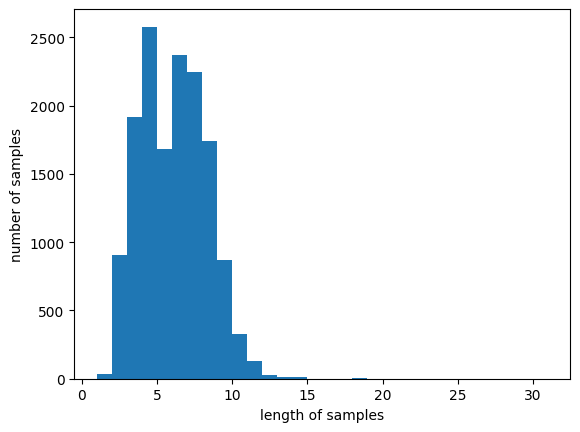

In [48]:
# 감성 단어 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['Sentiword']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['Sentiword']))/len(df_train['Sentiword']))
plt.hist([len(review) for review in df_train['Sentiword']], bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#임의로 설정한 한문장의 최대길이
max_length = 32

word piece시작

In [49]:
tokenizer = BertTokenizerFast.from_pretrained("kykim/albert-kor-base")

# BertTokenizerFast 객체를 피클로 저장
with open('./albert_tokenizer.pkl', "wb") as f:
    pickle.dump(tokenizer, f)

#리스트형태로 입력된다.
train_encodings = tokenizer(
    df_train['Sentiword'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_token_type_ids= False
) 


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizerFast'.


In [26]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [27]:
#데이터확인
#수치형 데이터
print(train_encodings['input_ids'][10035])
#토큰화된 텍스트
print(tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][10035]))
#원본텍스트
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][10035])))

[2, 5790, 8391, 8121, 14300, 3201, 8048, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['[CLS]', '움', '##츠', '##러', '##드는', '데', '##가', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[CLS] 움츠러드는 데가 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## 모델 시작

albert config
{
  "attention_probs_dropout_prob": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "embedding_size": 128,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_hidden_groups": 1,
  "net_structure_type": 0,
  "gap_size": 0,
  "num_memory_blocks": 0,
  "inner_group_num": 1,
  "down_scale_factor": 1,
  "type_vocab_size": 2,
  "vocab_size": 30000
}

In [39]:
# 입력 데이터로 변환
train_input_ids = np.array(train_encodings['input_ids'])
train_attention_mask = np.array(train_encodings['attention_mask'])

train_labels = np.array(df_train['Point'].apply(lambda x: x+2).tolist())

# 모델 구성 변경
config = AlbertConfig.from_pretrained("kykim/albert-kor-base")
config.num_hidden_layers = 10  # 레이어 수 변경
config.num_attention_heads = 10  #헤드수 변경
config.hidden_dropout_prob =0.2
config.hidden_size = 400  # 히든 사이즈 변경
config.num_labels = 5

# albert_model = TFAlbertForSequenceClassification.from_pretrained(
#     "kykim/albert-kor-base",
#     num_labels=5,
#     config=config)
# 변경된 모델 구성으로 새로운 모델 빌드
albert_model = TFAlbertForSequenceClassification(config=config)


In [40]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

albert_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)

In [41]:
#모델 빌드 
# 샘플 입력 데이터 생성
sample_input_ids = train_input_ids[:1]
sample_attention_mask = train_attention_mask[:1]

# 샘플 입력 데이터를 사용하여 모델을 호출하고 빌드
albert_model((sample_input_ids, sample_attention_mask))

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.03370582, -0.20713815,  0.07651331,  0.05325557,  0.11049046]],
      dtype=float32)>, hidden_states=None, attentions=None)

In [42]:
albert_model.summary()

Model: "tf_albert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  8725552   
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2005      
                                                                 
Total params: 8,727,557
Trainable params: 8,727,557
Non-trainable params: 0
_________________________________________________________________


In [44]:
# 모델 훈련
albert_model.fit(
    [train_input_ids, train_attention_mask],
    train_labels,
    batch_size=32,
    epochs=12,
    callbacks=[early_stop]
)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
#모델 저장# 폴더안에 가중치(json)와 함께 저장된다.
albert_model.save_pretrained('./emo_finetuned_albert-kor-base')